In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

image_dir = Path('D:/Image Classification/Indian Food Images')


filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    num_samples = min(100, len(category_slice))  # Ensure we sample at most 100 samples or all available samples if less than 100
    category_samples.append(category_slice.sample(num_samples, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)



: 

In [17]:
image_df['Label'].value_counts()


Label
biryani           50
chapati           50
aloo_tikki        50
jalebi            50
bhindi_masala     50
butter_chicken    50
chana_masala      50
dal_tadka         50
kadai_paneer      50
mysore_pak        50
aloo_gobi         50
Name: count, dtype: int64

In [18]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)


In [19]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [21]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 308 validated image filenames belonging to 11 classes.


Found 77 validated image filenames belonging to 11 classes.
Found 165 validated image filenames belonging to 11 classes.


In [22]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [25]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,439,883 (9.31 MB)

 Trainable params: 181,899 (710.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [26]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10


c:\Users\shriram\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 818ms/step - accuracy: 0.1578 - loss: 2.3027 - val_accuracy: 0.4286 - val_loss: 1.6681
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 554ms/step - accuracy: 0.7101 - loss: 1.3080 - val_accuracy: 0.6234 - val_loss: 1.2182
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 602ms/step - accuracy: 0.7849 - loss: 0.7141 - val_accuracy: 0.7013 - val_loss: 0.8883
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 580ms/step - accuracy: 0.9534 - loss: 0.3586 - val_accuracy: 0.6494 - val_loss: 0.9333
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 572ms/step - accuracy: 0.9499 - loss: 0.2418 - val_accuracy: 0.7273 - val_loss: 0.8320
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 591ms/step - accuracy: 0.9888 - loss: 0.1180 - val_accuracy: 0.7403 - val_loss: 0.6925
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 591ms/step - accuracy: 1.0000 - loss: 0.0485 - val_accuracy: 0.7662 - val_loss: 0.6626
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 551ms/step - accuracy: 1.0000 - loss: 0.0321 - val_accuracy: 0.7532 - val

In [27]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 83.64%


In [28]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 619ms/step


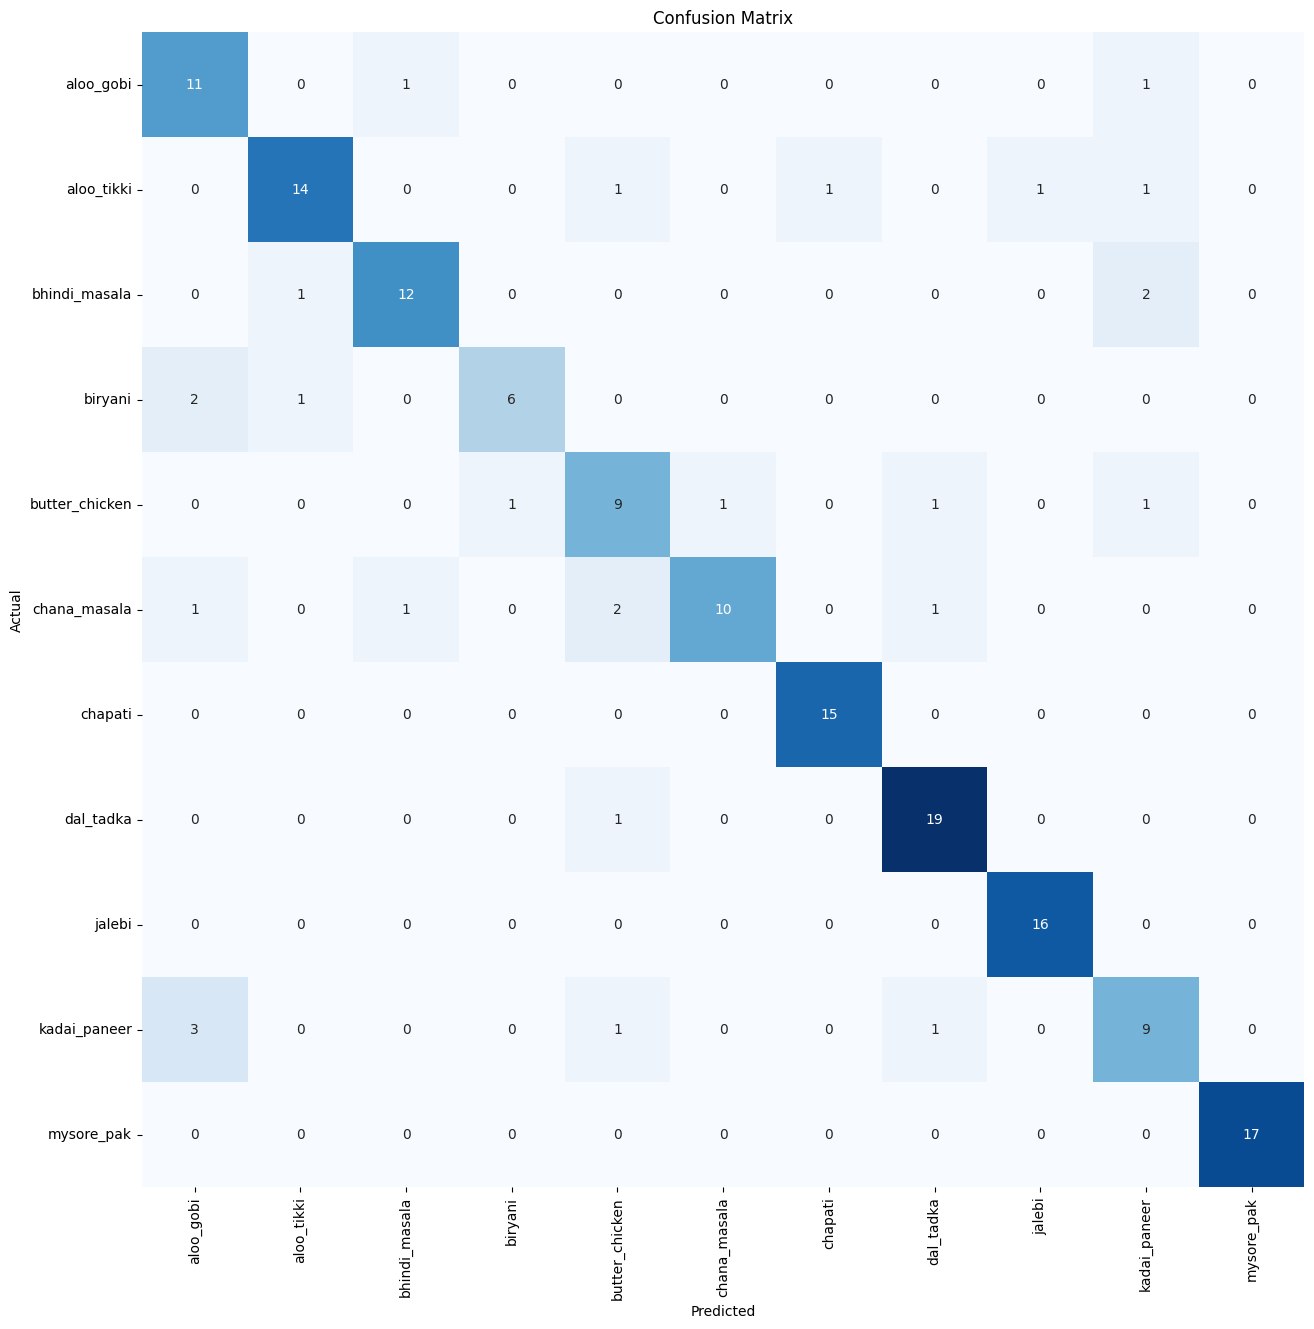

In [31]:
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(11) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(11) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [32]:
print("Classification Report:\n----------------------\n", clr)


Classification Report:
----------------------
                 precision    recall  f1-score   support

     aloo_gobi       0.65      0.85      0.73        13
    aloo_tikki       0.88      0.78      0.82        18
 bhindi_masala       0.86      0.80      0.83        15
       biryani       0.86      0.67      0.75         9
butter_chicken       0.64      0.69      0.67        13
  chana_masala       0.91      0.67      0.77        15
       chapati       0.94      1.00      0.97        15
     dal_tadka       0.86      0.95      0.90        20
        jalebi       0.94      1.00      0.97        16
  kadai_paneer       0.64      0.64      0.64        14
    mysore_pak       1.00      1.00      1.00        17

      accuracy                           0.84       165
     macro avg       0.83      0.82      0.82       165
  weighted avg       0.84      0.84      0.84       165



In [ ]:
import requests

def get_nutrient_info(food_name):
    api_key = '7PIXBDs3bVpYAXULAyWGTHQLhmSJi6roVWGtK5Rn'
    url = f'https://api.nal.usda.gov/fdc/v1/foods/search?query={food_name}&api_key={api_key}'
    
    response = requests.get(url)
    data = response.json()
    
    if 'foods' in data and len(data['foods']) > 0:
        food = data['foods'][0]
        nutrient_info = {
            'Food Name': food['description'],
            'Nutrients': {nutrient['nutrientName']: nutrient['value'] for nutrient in food['foodNutrients']}
        }
        return nutrient_info
    else:
        return None


In [ ]:
for i, prediction in enumerate(predictions):
    predicted_class = test_images.class_indices[prediction]
    classified_image_path = test_df.iloc[i]['Filepath']
    nutrient_info = get_nutrient_info(predicted_class)
    print("Predicted Class:", predicted_class)
    print("Nutrient Information:", nutrient_info)
    print()
